In [1]:
import os
import gin
import jax
import numpy as np
import jax.numpy as jnp
import optax
import scipy.linalg
import scipy.signal
import torch
import matplotlib.pyplot as plt
from flax import linen as nn
from torch.utils.data import Dataset, DataLoader
from dynamics.quadrotors import Quadrotors2D
from configs.dynamics.dynamics_config import Quadrotors2DConfig

def np_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [np_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

In [2]:
# Setup seed 
torch.random.manual_seed(0)
np.random.seed(0)
key = jax.random.PRNGKey(0)

Define Dynamics

In [3]:
path_to_dynamics_config_file = os.path.normpath(
    os.path.join(
        os.path.dirname(os.path.abspath("")),
        "configs/dynamics/quadrotors2D.gin",
        )
    )
gin.parse_config_file(path_to_dynamics_config_file)
dynamics_config = Quadrotors2DConfig()
dynamics = Quadrotors2D(dynamics_config)
dt = dynamics_config.dt


In [4]:
maximum_rollout_step = 200
xf = np.array([0,0,0,0,0,0])
uf = np.array([4.905, 4.905])
obs_min = np.array([-3,-3,-1.5,-5,-5,-2])
obs_max = np.array([3,3,1.5,5,5,2])

Q = np.eye(6)
R = np.eye(2)
R_inv = np.linalg.inv(R)

A = np.vstack([np.hstack([np.zeros((3,3)), np.eye(3)]),
                np.array([0,0,-dynamics.g, 0,0,0]),
                np.zeros((2,6))
                ])

B = np.vstack([np.zeros((4,2)),
                np.ones((1,2)) / dynamics.m,
                np.array([dynamics.r/dynamics.I, -dynamics.r/dynamics.I])])

P = scipy.linalg.solve_continuous_are(A, B, Q, R)
K = np.dot(R_inv, np.dot(B.T, P))

Define architectures

In [5]:
class PDValueApproximator(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = dynamics.states_wrap(x - xf)
        y = nn.Dense(128, use_bias=False)(x)
        y = nn.relu(y)
        y = nn.Dense(128, use_bias=False)(y)
        y = nn.relu(y)
        y = nn.Dense(64, use_bias=False)(y)
        y = jnp.einsum('...i,...i->...', y, y) + 1e-3 * jnp.einsum('...i,...i->...', x, x)

        return y.squeeze()
    
class SoftPDValueApproximator(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = dynamics.states_wrap(x - xf)
        y = nn.Dense(128)(x)
        y = nn.relu(y)
        y = nn.Dense(128)(y)
        y = nn.relu(y)
        y = nn.Dense(64)(y)
        y = nn.relu(y)
        y = nn.Dense(1)(y)

        return y.squeeze()

Define dataset

In [6]:
class StateDataset(Dataset):
    def __init__(self, xs):
        super().__init__()
        self.xs = xs
    def __len__(self):
        return len(self.xs)
    def __getitem__(self, index):
        return self.xs[index]

In [7]:
far_away = np.array([10,10,4,20,20,20])

def running_cost(x, u):
    x_diff = dynamics.states_wrap(x - xf)
    u_diff = u - uf
    return x_diff.T @ Q @ x_diff + u_diff.T @ R @ u_diff

def rollout_trajectory(get_control_efforts):
    trajectory = []
    cumulated_cost = 0
    x = dynamics.get_initial_state()
    within_range = True
    
    for i in range(maximum_rollout_step):

        if within_range:
            if np.any(dynamics.states_wrap(x - xf) > obs_max) or \
                np.any(dynamics.states_wrap(x - xf) < obs_min):
                within_range = False
            else:
                trajectory.append(x)
        
        u = get_control_efforts(x) 
        x = dynamics.simulate(x,u)
        cumulated_cost += dt * running_cost(x, u)

        # Without proper control, the drone can fly far away quickly yield very big cumulated cost.
        # For visialization purpose, we stop simulating when the drone fly far away.
        if np.any(np.abs(dynamics.states_wrap(x - xf)) > far_away):
            break

    return trajectory, cumulated_cost

In [8]:
dataset = StateDataset([xf]*256)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True, collate_fn=np_collate, drop_last=True)
pd_value_function_approximator = PDValueApproximator()
key, key_to_use = jax.random.split(key)
pd_model_variables = pd_value_function_approximator.init(key_to_use, jnp.zeros((1,6)))
pd_model_states, pd_model_params = pd_model_variables.pop('params')
del pd_model_variables
pd_optimizer = optax.adam(learning_rate=1e-3)
pd_optimizer_states = pd_optimizer.init(pd_model_params)

pd_cumulated_cost_during_learning_mean = []
pd_cumulated_cost_during_learning_std = []

def get_pd_control(x):
    u, v_gradient, updated_states = get_pd_control_with_additional_term(pd_model_params, pd_model_states, x)
    return np.asarray(u)

@jax.jit
def get_pd_control_with_additional_term(params, states, x):
    v_gradient, updated_states = get_pd_v_gradient(params, states, x)
    f_1, f_2 = dynamics.get_control_affine_matrix(x)
    # For the case when R is identity, the optimal u solve minimize the QP is by clipping
    u = jnp.clip(-R_inv @ f_2.T @ v_gradient / 2 + uf, dynamics.umin, dynamics.umax)
    return u, v_gradient, updated_states

@jax.jit
def get_pd_v_gradient(params, states, x):
    return jax.grad(pd_value_function_approximator.apply, argnums=1, has_aux=True)({'params': params, **states}, x, mutable=list(states.keys()))

def pd_hjb_loss(params, states, xs):
    def loss(x):
        f_1, f_2 = dynamics.get_control_affine_matrix(x)
        u, v_gradient, updated_states = get_pd_control_with_additional_term(params, states, x)
        x_dot = f_1 + f_2 @ u
        v_dot = v_gradient.T @ x_dot
        loss = jnp.abs(v_dot / (running_cost(x, u) + 1e-10) + 1)
        return loss, updated_states
    batch_losses, updated_states = jax.vmap(loss)(xs)
    return jnp.mean(batch_losses), updated_states

@jax.jit
def pd_params_update(params, states, optimizer_state, xs):
    (loss, updated_states), hjb_grad = jax.value_and_grad(pd_hjb_loss, has_aux=True)(params, states, xs)
    updates, optimizer_state = pd_optimizer.update(hjb_grad, optimizer_state)
    params = optax.apply_updates(params, updates)
    return params, updated_states, optimizer_state, loss

pd_losses = []
epochs = 150
for epoch in range(epochs):
    
    cumulated_cost_list = []
    trajectory_length = 0
    for _ in range(20):
        trajectory, cumulated_cost = rollout_trajectory(get_pd_control)
        trajectory_length += len(trajectory)
        cumulated_cost_list.append(cumulated_cost)
        dataset.xs.extend(trajectory)
    cumulated_cost_list = np.array(cumulated_cost_list)
    pd_cumulated_cost_during_learning_mean.append(np.mean(cumulated_cost_list))
    pd_cumulated_cost_during_learning_std.append(np.std(cumulated_cost_list))

    pd_total_loss = 0
    for i, xs in enumerate(dataloader):
        pd_model_params, pd_model_states, pd_optimizer_states, pd_loss = pd_params_update(pd_model_params, pd_model_states, pd_optimizer_states, xs)
        pd_total_loss += pd_loss

    pd_losses.append(pd_total_loss / len(dataloader))
    if (epoch+1) % 10 == 0:
        print(f"epoch:{epoch+1} loss:{pd_total_loss / len(dataloader)}, cumulated cost:{np.mean(cumulated_cost_list)}, avg trajectory length: {trajectory_length / 20}")

pd_cumulated_cost_during_learning_mean = np.array(pd_cumulated_cost_during_learning_mean)
pd_cumulated_cost_during_learning_std = np.array(pd_cumulated_cost_during_learning_std)

epoch:10 loss:0.86580890417099, cumulated cost:1369.2722040783722, avg trajectory length: 2.5
epoch:20 loss:0.4597087502479553, cumulated cost:313.5205699606769, avg trajectory length: 22.9
epoch:30 loss:0.27518609166145325, cumulated cost:428.81182642113146, avg trajectory length: 19.4


In [ ]:
regularization = 1e0
dataset = StateDataset([xf]*256)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True, collate_fn=np_collate, drop_last=True)
soft_pd_value_function_approximator = SoftPDValueApproximator()
key, key_to_use = jax.random.split(key)
soft_pd_model_variables = soft_pd_value_function_approximator.init(key_to_use, jnp.zeros((1,6)))
soft_pd_model_states, soft_pd_model_params = soft_pd_model_variables.pop('params')
del soft_pd_model_variables
soft_pd_optimizer = optax.adam(learning_rate=1e-3)
soft_pd_optimizer_states = soft_pd_optimizer.init(soft_pd_model_params)

soft_pd_cumulated_cost_during_learning_mean = []
soft_pd_cumulated_cost_during_learning_std = []

def get_soft_pd_control(x):
    u, value, v_gradient, updated_states = get_soft_pd_control_with_additional_term(soft_pd_model_params, soft_pd_model_states, x)
    return np.asarray(u)

@jax.jit
def get_soft_pd_control_with_additional_term(params, states, x):
    (value, updated_states), v_gradient = get_soft_pd_v_gradient(params, states, x)
    f_1, f_2 = dynamics.get_control_affine_matrix(x)
    u = jnp.clip(-R_inv @ f_2.T @ v_gradient / 2 + uf, dynamics.umin, dynamics.umax)
    return u, value, v_gradient, updated_states

def get_v_at_zeros(params, states):
    return soft_pd_value_function_approximator.apply({'params': params, **states}, xf)

def get_soft_pd_v_gradient(params, states, x):
    return jax.value_and_grad(soft_pd_value_function_approximator.apply, argnums=1, has_aux=True)({'params': params, **states}, x, mutable=list(states.keys()))

def soft_pd_hjb_loss(params, states, xs):
    def loss(x):
        f_1, f_2 = dynamics.get_control_affine_matrix(x)
        u, value, v_gradient, updated_states = get_soft_pd_control_with_additional_term(params, states, x)
        value_at_zero = get_v_at_zeros(params, states)
        x_dot = f_1 + f_2 @ u
        v_dot = v_gradient.T @ x_dot
        loss = jnp.abs(v_dot / (running_cost(x, u) + 1e-10) + 1) + regularization * jnp.maximum(0, value_at_zero-value)
        return loss, updated_states
    batch_losses, updated_states = jax.vmap(loss)(xs)
    return jnp.mean(batch_losses), updated_states

def soft_pd_warmup_hjb_loss(params, states, xs):
    def loss(x):
        f_1, f_2 = dynamics.get_control_affine_matrix(x)
        _, value, v_gradient, updated_states = get_soft_pd_control_with_additional_term(params, states, x)
        value_at_zero = get_v_at_zeros(params, states)
        u = jnp.clip(-K @ dynamics.states_wrap(x - xf) + uf, dynamics.umin, dynamics.umax)
        x_dot = f_1 + f_2 @ u
        v_dot = v_gradient.T @ x_dot
        loss = jnp.abs(v_dot / (running_cost(x, u) + 1e-10) + 1) + regularization * jnp.maximum(0, value_at_zero-value)
        return loss, updated_states
    batch_losses, updated_states = jax.vmap(loss)(xs)
    return jnp.mean(batch_losses), updated_states

@jax.jit
def soft_pd_params_update(params, states, optimizer_state, xs):
    (loss, updated_states), hjb_grad = jax.value_and_grad(soft_pd_hjb_loss, has_aux=True)(params, states, xs)
    updates, optimizer_state = soft_pd_optimizer.update(hjb_grad, optimizer_state)
    params = optax.apply_updates(params, updates)
    return params, updated_states, optimizer_state, loss

@jax.jit
def soft_pd_params_warmup_update(params, states, optimizer_state, xs):
    (loss, updated_states), hjb_grad = jax.value_and_grad(soft_pd_warmup_hjb_loss, has_aux=True)(params, states, xs)
    updates, optimizer_state = soft_pd_optimizer.update(hjb_grad, optimizer_state)
    params = optax.apply_updates(params, updates)
    return params, updated_states, optimizer_state, loss

soft_pd_losses = []
step = 0

warmup_epochs = 50
for warmup_epoch in range(warmup_epochs):
    cumulated_cost_list = []
    trajectory_length = 0
    for _ in range(20):
        trajectory, cumulated_cost = rollout_trajectory(get_soft_pd_control)
        trajectory_length += len(trajectory)
        cumulated_cost_list.append(cumulated_cost)
        dataset.xs.extend(trajectory)
    cumulated_cost_list = np.array(cumulated_cost_list)
    soft_pd_cumulated_cost_during_learning_mean.append(np.mean(cumulated_cost_list))
    soft_pd_cumulated_cost_during_learning_std.append(np.std(cumulated_cost_list))

    soft_pd_total_loss = 0
    for i, xs in enumerate(dataloader):
        soft_pd_model_params, soft_pd_model_states, soft_pd_optimizer_states, soft_pd_loss = soft_pd_params_warmup_update(soft_pd_model_params, soft_pd_model_states, soft_pd_optimizer_states, xs)
        soft_pd_total_loss += soft_pd_loss
    soft_pd_losses.append(soft_pd_total_loss / len(dataloader))
    if (warmup_epoch+1) % 10 == 0:
        print(f"warmup epoch:{warmup_epoch+1} loss:{soft_pd_total_loss / len(dataloader)}, cumulated cost:{np.mean(cumulated_cost_list)}, avg trajectory length: {trajectory_length / 20}")
        
for epoch in range(warmup_epochs, epochs, 1):
    cumulated_cost_list = []
    trajectory_length = 0
    for _ in range(20):
        trajectory, cumulated_cost = rollout_trajectory(get_soft_pd_control)
        trajectory_length += len(trajectory)
        cumulated_cost_list.append(cumulated_cost)
        dataset.xs.extend(trajectory)

    cumulated_cost_list = np.array(cumulated_cost_list)
    soft_pd_cumulated_cost_during_learning_mean.append(np.mean(cumulated_cost_list))
    soft_pd_cumulated_cost_during_learning_std.append(np.std(cumulated_cost_list))
    
    soft_pd_total_loss = 0
    for i, xs in enumerate(dataloader):
        soft_pd_model_params, soft_pd_model_states, soft_pd_optimizer_states, soft_pd_loss = soft_pd_params_update(soft_pd_model_params, soft_pd_model_states, soft_pd_optimizer_states, xs)
        soft_pd_total_loss += soft_pd_loss
    soft_pd_losses.append(soft_pd_total_loss / len(dataloader))
    if (epoch+1) % 10 == 0:
        print(f"epoch:{epoch+1} loss:{soft_pd_total_loss / len(dataloader)}, cumulated cost:{np.mean(cumulated_cost_list)}, avg trajectory length: {trajectory_length / 20}")

soft_pd_cumulated_cost_during_learning_mean = np.array(soft_pd_cumulated_cost_during_learning_mean)
soft_pd_cumulated_cost_during_learning_std = np.array(soft_pd_cumulated_cost_during_learning_std)

warmup epoch:10 loss:0.6635186076164246, cumulated cost:214.03036418865227, avg trajectory length: 19.1
warmup epoch:20 loss:0.7303176522254944, cumulated cost:232.5517420225198, avg trajectory length: 29.15
warmup epoch:30 loss:0.6019261479377747, cumulated cost:126.07104895990187, avg trajectory length: 87.95
warmup epoch:40 loss:0.5665321946144104, cumulated cost:82.00229061537622, avg trajectory length: 67.55
warmup epoch:50 loss:0.5113286972045898, cumulated cost:63.063892464676314, avg trajectory length: 123.2
warmup epoch:60 loss:0.5216265916824341, cumulated cost:88.04157974875513, avg trajectory length: 92.8
warmup epoch:70 loss:0.4625175893306732, cumulated cost:46.65584711205272, avg trajectory length: 152.0
warmup epoch:80 loss:0.4378381073474884, cumulated cost:18.665597434507465, avg trajectory length: 150.85
warmup epoch:90 loss:0.40277209877967834, cumulated cost:56.17041545178709, avg trajectory length: 121.7
warmup epoch:100 loss:0.4051330089569092, cumulated cost:19.

In [ ]:
regularization = 1e0
dataset = StateDataset([xf]*256)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True, collate_fn=np_collate, drop_last=True)
key, key_to_use = jax.random.split(key)
soft_pd_model_without_warmup_variables = soft_pd_value_function_approximator.init(key_to_use, jnp.zeros((1,6)))
soft_pd_model_without_warmup_states, soft_pd_model_without_warmup_params = soft_pd_model_without_warmup_variables.pop('params')
del soft_pd_model_without_warmup_variables
soft_pd_optimizer_without_warmup_states = soft_pd_optimizer.init(soft_pd_model_without_warmup_params)

soft_pd_without_warmup_cumulated_cost_during_learning_mean = []
soft_pd_without_warmup_cumulated_cost_during_learning_std = []
soft_pd_without_warmup_losses = []

def get_soft_pd_without_warmup_control(x):
    u, value, v_gradient, updated_states = get_soft_pd_control_with_additional_term(soft_pd_model_without_warmup_params, soft_pd_model_without_warmup_states, x)
    return np.asarray(u)

for epoch in range(epochs):
    cumulated_cost_list = []
    trajectory_length = 0
    for _ in range(20):
        trajectory, cumulated_cost = rollout_trajectory(get_soft_pd_without_warmup_control)
        trajectory_length += len(trajectory)
        cumulated_cost_list.append(cumulated_cost)
        dataset.xs.extend(trajectory)
    cumulated_cost_list = np.array(cumulated_cost_list)
    soft_pd_without_warmup_cumulated_cost_during_learning_mean.append(np.mean(cumulated_cost_list))
    soft_pd_without_warmup_cumulated_cost_during_learning_std.append(np.std(cumulated_cost_list))

    soft_pd_without_warmup_total_loss = 0
    for i, xs in enumerate(dataloader):
        soft_pd_model_without_warmup_params, soft_pd_model_without_warmup_states, soft_pd_optimizer_without_warmup_states, soft_pd_without_warmup_loss = soft_pd_params_update(soft_pd_model_without_warmup_params, soft_pd_model_without_warmup_states, soft_pd_optimizer_without_warmup_states, xs)
        soft_pd_without_warmup_total_loss += soft_pd_loss
    soft_pd_without_warmup_losses.append(soft_pd_without_warmup_total_loss / len(dataloader))
    if (epoch+1) % 10 == 0:
        print(f"epoch:{epoch+1} loss:{soft_pd_without_warmup_total_loss / len(dataloader)}, cumulated cost:{np.mean(cumulated_cost_list)}, avg trajectory length: {trajectory_length / 20}")

soft_pd_without_warmup_cumulated_cost_during_learning_mean = np.array(soft_pd_without_warmup_cumulated_cost_during_learning_mean)
soft_pd_without_warmup_cumulated_cost_during_learning_std = np.array(soft_pd_without_warmup_cumulated_cost_during_learning_std)

epoch:10 loss:0.3044946491718292, cumulated cost:394.9834573975143, avg trajectory length: 4.2
epoch:20 loss:0.3044946491718292, cumulated cost:294.2439121394199, avg trajectory length: 4.95
epoch:30 loss:0.3044946789741516, cumulated cost:207.9564682648557, avg trajectory length: 6.3
epoch:40 loss:0.3044947385787964, cumulated cost:184.60842104189163, avg trajectory length: 5.4
epoch:50 loss:0.3044947385787964, cumulated cost:176.59992122984153, avg trajectory length: 5.65
epoch:60 loss:0.3044947683811188, cumulated cost:171.31298539280715, avg trajectory length: 8.9
epoch:70 loss:0.3044947683811188, cumulated cost:168.9159819161775, avg trajectory length: 5.05
epoch:80 loss:0.30449479818344116, cumulated cost:132.93669516492142, avg trajectory length: 5.15
epoch:90 loss:0.30449479818344116, cumulated cost:128.56166437140098, avg trajectory length: 4.75
epoch:100 loss:0.30449479818344116, cumulated cost:139.62062578623522, avg trajectory length: 4.85
epoch:110 loss:0.30449482798576355

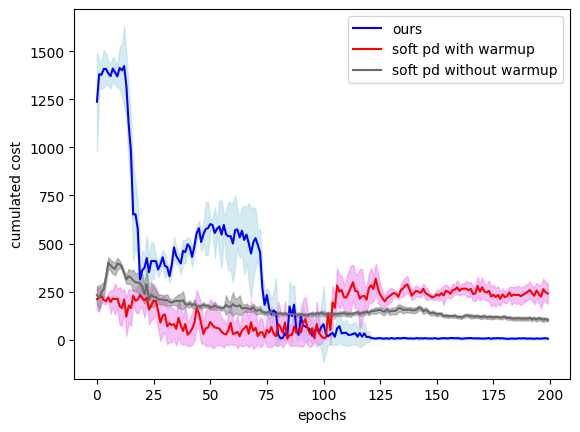

In [ ]:
plt.figure()

plt.plot(pd_cumulated_cost_during_learning_mean, color="blue", label="ours")
plt.fill_between(range(len(pd_cumulated_cost_during_learning_mean)), 
                 pd_cumulated_cost_during_learning_mean+pd_cumulated_cost_during_learning_std, 
                 pd_cumulated_cost_during_learning_mean-pd_cumulated_cost_during_learning_std, color="lightblue", alpha=0.5)

plt.plot(soft_pd_cumulated_cost_during_learning_mean, color="red", label="soft pd with warmup")
plt.fill_between(range(len(soft_pd_cumulated_cost_during_learning_mean)),
                soft_pd_cumulated_cost_during_learning_mean+soft_pd_cumulated_cost_during_learning_std, 
                soft_pd_cumulated_cost_during_learning_mean - soft_pd_cumulated_cost_during_learning_std,
                color="violet", alpha=0.5)

plt.plot(soft_pd_without_warmup_cumulated_cost_during_learning_mean, color="dimgray", label="soft pd without warmup")
plt.fill_between(range(len(soft_pd_cumulated_cost_during_learning_mean)),
                soft_pd_without_warmup_cumulated_cost_during_learning_mean + soft_pd_without_warmup_cumulated_cost_during_learning_std, 
                soft_pd_without_warmup_cumulated_cost_during_learning_mean - soft_pd_without_warmup_cumulated_cost_during_learning_std,
                color="gray", alpha=0.5)

plt.legend()
plt.xlabel("epochs")
plt.ylabel("cumulated cost")
plt.show()

Test policy

In [ ]:
def get_LQR_control(x):
     return np.clip(-K @ dynamics.states_wrap(x - xf) + uf, dynamics.umin, dynamics.umax)

def test_learned_policy(x0, T=10):
    ts = np.arange(0, T, dt)
    
    xs_pd = [x0]
    xs_soft_pd = [x0]
    xs_soft_pd_without_warmup = [x0]
    xs_lqr = [x0]
    
    us_pd = []
    us_soft_pd = []
    us_soft_pd_without_warmup = []
    us_lqr = []

    cost_pd = 0
    cost_lqr = 0
    cost_soft_pd = 0
    cost_soft_pd_without_warmup = 0

    for t in ts:
        if np.all(np.abs(dynamics.states_wrap(xs_pd[-1] - xf)) <= far_away):
            us_pd.append(get_pd_control(xs_pd[-1]))
            cost_pd += running_cost(xs_pd[-1], us_pd[-1]) * dt
            xs_pd.append(dynamics.simulate(xs_pd[-1], us_pd[-1]))
        if np.all(np.abs(dynamics.states_wrap(xs_lqr[-1] - xf)) <= far_away):
            us_lqr.append(get_LQR_control(xs_lqr[-1]))
            cost_lqr += running_cost(xs_lqr[-1], us_lqr[-1]) * dt
            xs_lqr.append(dynamics.simulate(xs_lqr[-1], us_lqr[-1]))
        if np.all(np.abs(dynamics.states_wrap(xs_soft_pd[-1] - xf)) <= far_away):
            us_soft_pd.append(get_soft_pd_control(xs_soft_pd[-1]))
            cost_soft_pd += running_cost(xs_soft_pd[-1], us_soft_pd[-1]) * dt
            xs_soft_pd.append(dynamics.simulate(xs_soft_pd[-1], us_soft_pd[-1]))
        if np.all(np.abs(dynamics.states_wrap(xs_soft_pd_without_warmup[-1] - xf)) <= far_away):
            us_soft_pd_without_warmup.append(np.array(get_soft_pd_without_warmup_control(xs_soft_pd_without_warmup[-1])))
            cost_soft_pd_without_warmup += running_cost(xs_soft_pd_without_warmup[-1], us_soft_pd_without_warmup[-1]) * dt
            xs_soft_pd_without_warmup.append(dynamics.simulate(xs_soft_pd_without_warmup[-1], us_soft_pd_without_warmup[-1]))

    xs_pd = np.array(xs_pd)
    xs_soft_pd = np.array(xs_soft_pd)
    xs_soft_pd_without_warmup = np.array(xs_soft_pd_without_warmup)
    xs_lqr = np.array(xs_lqr)

    return ts, xs_pd, xs_soft_pd, xs_soft_pd_without_warmup, xs_lqr, cost_pd, cost_soft_pd, cost_soft_pd_without_warmup, cost_lqr
def visualize_traj(xs_pd, xs_soft_pd, xs_soft_pd_without_warmup, xs_lqr):
    r = 0.05

    fig, ax = plt.subplots()

    ax.plot(xs_pd[:,0], xs_pd[:,1], '--b', label="ours")
    ax.plot([xs_pd[-1,0] - r * np.cos(xs_pd[-1,2]),
                xs_pd[-1,0] + r * np.cos(xs_pd[-1,2])],
            [xs_pd[-1,1] - r * np.sin(xs_pd[-1,2]),
                xs_pd[-1,1] + r * np.sin(xs_pd[-1,2])], '-b')
    
    ax.plot(xs_lqr[:,0], xs_lqr[:,1], '--g', label="lqr")
    ax.plot([xs_lqr[-1,0] - r * np.cos(xs_lqr[-1,2]),
                xs_lqr[-1,0] + r * np.cos(xs_lqr[-1,2])],
            [xs_lqr[-1,1] - r * np.sin(xs_lqr[-1,2]),
                xs_lqr[-1,1] + r * np.sin(xs_lqr[-1,2])], '-g')
    
    ax.set_ylim(ax.get_ylim())
    ax.set_xlim(ax.get_xlim())

    ax.plot(xs_soft_pd[:,0], xs_soft_pd[:,1], '--r', label="soft pd")
    ax.plot([xs_soft_pd[-1,0] - r * np.cos(xs_soft_pd[-1,2]),
                xs_soft_pd[-1,0] + r * np.cos(xs_soft_pd[-1,2])],
            [xs_soft_pd[-1,1] - r * np.sin(xs_soft_pd[-1,2]),
                xs_soft_pd[-1,1] + r * np.sin(xs_soft_pd[-1,2])], '-r')
    
    ax.plot(xs_soft_pd_without_warmup[:,0], xs_soft_pd_without_warmup[:,1], '--', color="grey", label="soft pd without warmup")
    ax.plot([xs_soft_pd_without_warmup[-1,0] - r * np.cos(xs_soft_pd_without_warmup[-1,2]),
                xs_soft_pd_without_warmup[-1,0] + r * np.cos(xs_soft_pd_without_warmup[-1,2])],
            [xs_soft_pd_without_warmup[-1,1] - r * np.sin(xs_soft_pd_without_warmup[-1,2]),
                xs_soft_pd_without_warmup[-1,1] + r * np.sin(xs_soft_pd_without_warmup[-1,2])], '-', color="grey")
    
    ax.plot(xf[0], xf[1], 'c*', label="desired position")
    ax.set_xlabel("x(meter)")
    ax.set_ylabel("y(meter)")
    ax.legend()

pd:  1.3495699849123834
lqr:  1.335421313313018
soft pd:  145.04981338543774
soft pd without warmup: 91.65797906338409
mean pd:  9.389088978546102
mean lqr:  9.983921427754535
mean soft pd:  221.43880418336758
mean soft pd without warmup: 82.44807182720768


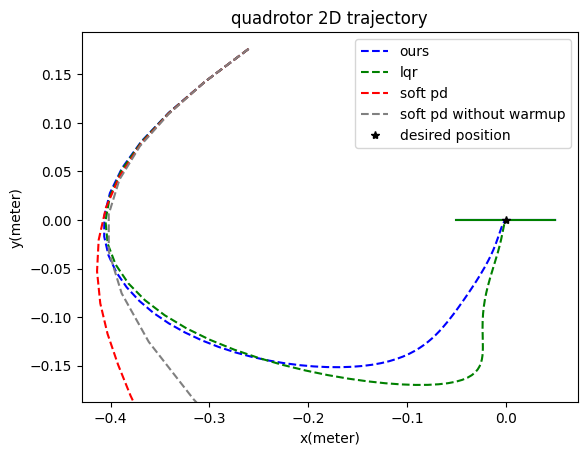

In [ ]:
x0 = dynamics.get_initial_state()
ts, xs_pd, xs_soft_pd, xs_soft_pd_without_warmup, xs_lqr, cost_pd, cost_soft_pd, cost_soft_pd_without_warmup, cost_lqr= test_learned_policy(x0)

cost_pd_list = [cost_pd]
cost_lqr_list = [cost_lqr]
cost_soft_pd_list = [cost_soft_pd]
cost_soft_pd_without_warmup_list = [cost_soft_pd_without_warmup]

print("pd: ", cost_pd)
print("lqr: ", cost_lqr)
print("soft pd: ", cost_soft_pd)
print("soft pd without warmup:", cost_soft_pd_without_warmup)

visualize_traj(xs_pd, xs_soft_pd, xs_soft_pd_without_warmup, xs_lqr)

for i in range(1, 10):
    x0 = dynamics.get_initial_state()
    ts, xs_pd, xs_soft_pd, xs_soft_pd_without_warmup, xs_lqr, cost_pd, cost_soft_pd, cost_soft_pd_without_warmup, cost_lqr = test_learned_policy(x0)
    cost_pd_list.append(cost_pd)
    cost_lqr_list.append(cost_lqr)
    cost_soft_pd_list.append(cost_soft_pd)
    cost_soft_pd_without_warmup_list.append(cost_soft_pd_without_warmup)

cost_pd_list = np.array(cost_pd_list)
cost_lqr_list = np.array(cost_lqr_list)
cost_soft_pd_list = np.array(cost_soft_pd_list)
cost_soft_pd_without_warmup_list = np.array(cost_soft_pd_without_warmup_list)
print("mean pd: ", np.mean(cost_pd_list))
print("mean lqr: ", np.mean(cost_lqr_list))
print("mean soft pd: ", np.mean(cost_soft_pd_list))
print("mean soft pd without warmup:", np.mean(cost_soft_pd_without_warmup_list))